A naive approach for 'Intel & MobileODT Cervical Cancer Screening' competition using fine-tuned Inception V3 convolutional neural network.

In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras import backend as K
from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

from six.moves import cPickle as pickle
#from six.moves import range
#from scipy import ndimage
import os

import PIL.Image
from cStringIO import StringIO
import IPython.display

Using TensorFlow backend.


Functions to load images from files, resize and convert to a matrix using keras.preprocessing.image.

In [2]:
def load_image_filenames(folders):
    image_files = []
    
    for folder_tuple in folders:
        folder = folder_tuple[0]
        label_index = folder_tuple[1] - 1

        image_filepaths = [os.path.join(folder, image_filename) for image_filename in os.listdir(folder)]
        image_files.extend([(image_filepath, label_index) for image_filepath in image_filepaths])
        
    return image_files

def load_image(filename, target_size):
    try:
        img = image.load_img(filename, target_size=target_size)
    except IOError as e:
        print('Could not read:', filename, ':', e, ', skipping.')
        return None

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
    
def load_images(image_files, target_size):
    x_list = []
    y_list = []
    
    for image_file in image_files:
        image_filepath = image_file[0]
        label_index = image_file[1]

        x = load_image(image_filepath, target_size)
        if x == None:
            continue
            
        x_list.append(x)

        y = np.zeros((1, 3))
        y[0, label_index] = 1
        y_list.append(y)
        
    X = np.vstack(x_list)
    y = np.vstack(y_list)
    
    return X, y

Functions to convert image pixels from -1:1 range to 0:255 range and to display an image.

In [3]:
def denormalize_input(x):
    """
    Converts image pixels from -1:1 range to 0:255 range.
    """
    x /= 2.
    x += 0.5
    x *= 255.
    return x

In [4]:
def show_array(a, fmt='png'):
    """
    Displays an image inside of Jupyter notebook.
    """
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

A function to display a confusion matrix and a classification report.

In [ ]:
def show_report(model, X, y):
    """
    Displays a confusion matrix and a classification report.
    """
    y_predicted = np.argmax(model.predict(X), axis=1)
    y_true = np.argmax(y, axis=1)

    print("Confusion matrix (rows: true, columns: predicted)")
    print(confusion_matrix(y_true, y_predicted))
    print("")

    print("Classification report")
    print(classification_report(y_true, y_predicted))

**Data loading and pre-processing**  
Load images from 'train' and 'additional' folders, shuffle and split into train and dev sets in 80/20 proportion.

In [5]:
train_folders = [('train/Type_1/', 1), ('train/Type_2/', 2), ('train/Type_3/', 3), 
                ('additional/Type_1/', 1), ('additional/Type_2/', 2), ('additional/Type_3/', 3)]

In [6]:
for folder_tuple in train_folders:
    print(folder_tuple[0], len(os.listdir(folder_tuple[0])))

train/Type_1/ 250
train/Type_2/ 781
train/Type_3/ 450
additional/Type_1/ 1191
additional/Type_2/ 3567
additional/Type_3/ 1976


In [7]:
target_size=(224, 224)
train_fraction = 0.8

In [8]:
image_files = load_image_filenames(train_folders)
np.random.seed(42)
np.random.shuffle(image_files)
print('files', len(image_files))

train_count = int(len(image_files) * train_fraction)

train_files = image_files[0:train_count]
dev_files = image_files[train_count:]

print('train_files', len(train_files))
print('dev_files', len(dev_files))

X_train, y_train = load_images(train_files, target_size=target_size)
X_dev, y_dev = load_images(dev_files, target_size=target_size)

files 8215
train_files 6572
dev_files 1643


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Could not read: train/Type_1/1339.jpg : image file is truncated (54 bytes not processed) , skipping.
Could not read: additional/Type_1/3068.jpg : image file is truncated (108 bytes not processed) , skipping.
Could not read: additional/Type_2/5892.jpg : cannot identify image file 'additional/Type_2/5892.jpg' , skipping.
Could not read: additional/Type_2/2845.jpg : cannot identify image file 'additional/Type_2/2845.jpg' , skipping.
Could not read: additional/Type_2/7.jpg : image file is truncated (36 bytes not processed) , skipping.
Could not read: additional/Type_1/5893.jpg : cannot identify image file 'additional/Type_1/5893.jpg' , skipping.


Show first 5 images.

('additional/Type_2/3955.jpg', 1)


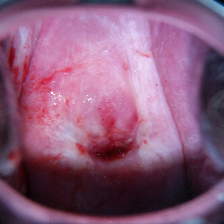

('additional/Type_3/1334.jpg', 2)


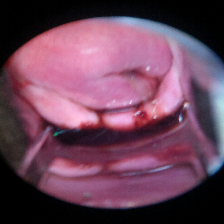

('additional/Type_2/4949.jpg', 1)


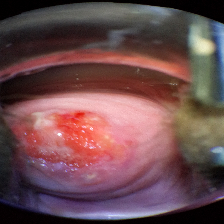

('additional/Type_1/1539.jpg', 0)


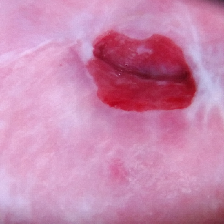

('additional/Type_1/6919.jpg', 0)


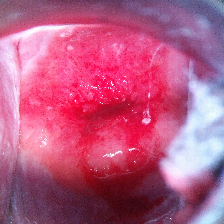

In [9]:
for i in range(5):
    print(train_files[i])
    show_array(denormalize_input(X_train[i,:,:,:].reshape(224, 224, 3)))

**Model training**  
Load pre-trained Inception V3 model, add a fully-connected layer and a softmax layer on top, train just these new layers on the training set.

In [17]:
dropout_probability = 0.3
dense_layer_size = 512
batch_size = 64
epoch_count = 20

In [18]:
np.random.seed(42)

base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(dense_layer_size, activation='relu')(x)

# add a dropout layer for regularization
dropout = Dropout(dropout_probability)(x)

# and a logistic layer
predictions = Dense(3, activation='softmax')(dropout)

model = Model(input=base_model.input, output=predictions)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epoch_count, verbose=2, validation_data=(X_dev, y_dev), callbacks=[])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Train on 6568 samples, validate on 1641 samples
Epoch 1/20
39s - loss: 1.5378 - val_loss: 0.9833
Epoch 2/20
39s - loss: 0.9786 - val_loss: 1.1396
Epoch 3/20
39s - loss: 0.9602 - val_loss: 0.9544
Epoch 4/20
39s - loss: 0.9339 - val_loss: 0.9810
Epoch 5/20
39s - loss: 0.9204 - val_loss: 0.9540
Epoch 6/20
39s - loss: 0.9021 - val_loss: 0.9512
Epoch 7/20
39s - loss: 0.8880 - val_loss: 0.9414
Epoch 8/20
39s - loss: 0.8774 - val_loss: 1.0162
Epoch 9/20
39s - loss: 0.8560 - val_loss: 0.9547
Epoch 10/20
39s - loss: 0.8321 - val_loss: 0.9982
Epoch 11/20
39s - loss: 0.8183 - val_loss: 1.0354
Epoch 12/20
39s - loss: 0.8105 - val_loss: 0.9521
Epoch 13/20
39s - loss: 0.7732 - val_loss: 0.9866
Epoch 14/20
39s - loss: 0.7740 - val_loss: 1.0213
Epoch 15/20
39s - loss: 0.7504 - val_loss: 1.0010
Epoch 16/20
39s - loss: 0.7323 - val_loss: 0.9850
Epoch 17/20
39s - loss: 0.6998 - val_loss: 1.1401
Epoch 18/20
39s - loss: 0.6878 - val_loss: 0.9980
Epoch 19/20
39s - loss: 0.6702 - val_loss: 0.9947
Epoch 20/20

In [19]:
show_report(model, X_dev, y_dev)

Confusion matrix (rows: true, columns: predicted)
[[  2 242  30]
 [  8 697 195]
 [  1 276 190]]

Classification report
             precision    recall  f1-score   support

          0       0.18      0.01      0.01       274
          1       0.57      0.77      0.66       900
          2       0.46      0.41      0.43       467

avg / total       0.48      0.54      0.49      1641



Now start fine-tuning convolutional layers from inception V3. Freeze 249 bottom layers and train the remaining top layers (2 inception blocks).

In [20]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

In [21]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

model.fit(x=X_train, y=y_train, batch_size=32, epochs=epoch_count, verbose=2, validation_data=(X_dev, y_dev))

Train on 6568 samples, validate on 1641 samples
Epoch 1/20
48s - loss: 0.6752 - val_loss: 1.0029
Epoch 2/20
47s - loss: 0.5873 - val_loss: 1.0049
Epoch 3/20
47s - loss: 0.5422 - val_loss: 1.0128
Epoch 4/20
47s - loss: 0.5174 - val_loss: 0.9964
Epoch 5/20
47s - loss: 0.4968 - val_loss: 0.9873
Epoch 6/20
47s - loss: 0.4635 - val_loss: 1.0050
Epoch 7/20
47s - loss: 0.4501 - val_loss: 1.0075
Epoch 8/20
47s - loss: 0.4260 - val_loss: 1.0127
Epoch 9/20
47s - loss: 0.4098 - val_loss: 1.0255
Epoch 10/20
47s - loss: 0.3924 - val_loss: 1.0248
Epoch 11/20
47s - loss: 0.3662 - val_loss: 1.0239
Epoch 12/20
47s - loss: 0.3516 - val_loss: 1.0387
Epoch 13/20
47s - loss: 0.3439 - val_loss: 1.0303
Epoch 14/20
47s - loss: 0.3293 - val_loss: 1.0517
Epoch 15/20
47s - loss: 0.3060 - val_loss: 1.0521
Epoch 16/20
47s - loss: 0.2885 - val_loss: 1.0455
Epoch 17/20
47s - loss: 0.2864 - val_loss: 1.0715
Epoch 18/20
47s - loss: 0.2764 - val_loss: 1.0521
Epoch 19/20
47s - loss: 0.2702 - val_loss: 1.0818
Epoch 20/20

In [22]:
show_report(model, X_dev, y_dev)

Confusion matrix (rows: true, columns: predicted)
[[ 60 179  35]
 [ 80 641 179]
 [ 34 239 194]]

Classification report
             precision    recall  f1-score   support

          0       0.34      0.22      0.27       274
          1       0.61      0.71      0.65       900
          2       0.48      0.42      0.44       467

avg / total       0.52      0.55      0.53      1641



**Preparing a submission file**  
Load a test set and make prediction.

In [23]:
test_folder = 'test/'

test_filenames = os.listdir(test_folder)

x_list = []
for filename in test_filenames:
    x = load_image(os.path.join(test_folder, filename), target_size)
    if x == None:
        x = np.zeros(shape=target_size, dtype=float32)
    x_list.append(x)
    
X_test = np.vstack(x_list)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [24]:
y_test = model.predict(X_test)

submission = pd.read_csv("sample_submission.csv")

for i in range(len(test_filenames)):
    filename = test_filenames[i]
    line = filename
    for j in range(3):
        submission.loc[submission['image_name'] == filename, 'Type_' + str(j + 1)] = y_test[i, j]

submission.to_csv("submission.csv", index=False)